In [2]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from model import ShadowNet
from misc import loadModel, crf_refine

In [12]:
c = torch.rand(10,10).lt(0.30).float()
c

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [13]:
c.sum()

tensor(27.)

In [7]:
class Demo:
    def __init__(self, modelPath = "./models/models/SBU_4700.pt"):
        self.net = GCNet().cuda()
        loadModel(self.net, modelPath)
        self.net.eval()
    
    def prepare(self, img):
        img = torchvision.transforms.ToTensor()(
            torchvision.transforms.Resize( (320,320) )(
                img
            )
        )
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = torchvision.transforms.Normalize(mean, std)(img)
        return img.unsqueeze(0).cuda()
    
    def postProcess(self, img, pred):
        size = tuple(reversed(img.size))
        pred = torchvision.transforms.ToPILImage()( nn.Sigmoid()( pred["final"][0][0][0] ).cpu() )
        pred = torchvision.transforms.Resize(size)(pred)
        pred_crf = crf_refine(
            np.array(img),
            np.array(pred)
        )
        return pred_crf
    
    def detect(self, img_path):
        img = Image.open(img_path)
        pred = self.net(self.prepare(img))
        pred_crf = self.postProcess(img, pred)
        return img, Image.fromarray(pred_crf)
    

In [8]:
demo = Demo()
img, pred = demo.detect("./samples/1.jpg")
img, pred

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E09E030F40>,
 <PIL.Image.Image image mode=L size=600x450 at 0x1E0F149A760>)

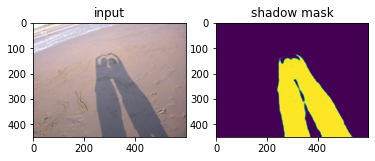

In [9]:
plt.subplot(121)
plt.imshow(img)
plt.title("input")
plt.subplot(122)
plt.imshow(pred)
plt.title("shadow mask")
plt.show()